In [ ]:
pip install duckdb matplotlib seaborn pandas

In [1]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

In [2]:
## Helper functions
def format_large_numbers(x, pos):
    if x >= 1e9:
        return f'{x/1e9:.1f}B'
    elif x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    return f'{x:.0f}'

usd_formatter = FuncFormatter(format_large_numbers)

def plot_styled_barchart(df, x, y, title):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df, x=x, y=y, palette='viridis')
    plt.title(title, fontsize=14, pad=20)
    ax.xaxis.set_tick_params(rotation=45)
    ax.yaxis.set_major_formatter(usd_formatter)
    plt.tight_layout()
    plt.show()
    
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [32]:
# Connect to DuckDB (
con = duckdb.connect('blockchain.duckdb')

## drop all tables if they exist
con.execute("drop SCHEMA  staging cascade;")
con.execute("drop SCHEMA reporting cascade;")

# Create schemas if they do not exist
con.execute("CREATE SCHEMA IF NOT EXISTS staging;")
con.execute("CREATE SCHEMA IF NOT EXISTS reporting;")

# Load CSV as all VARCHAR into a staging table for swaps
con.execute("""
CREATE OR REPLACE TABLE staging.swaps AS
SELECT * FROM read_csv_auto('/Users/jabulaninyoni/Documents/BBTest/swaps.csv', all_varchar=True, header=True);
""")

In [33]:
count= con.execute("""select count(1) from staging.swaps;""").fetchdf()
count


,count(1)
0,9240141


In [34]:
# Create the final table for swaps by casting each column
con.execute("""
CREATE OR REPLACE TABLE reporting.swaps AS
SELECT
    chain,
    protocol,
    CAST(block_number AS BIGINT) AS block_number,
    CAST(block_timestamp AS TIMESTAMP) AS block_timestamp,
    hash,
    CAST(log_index AS BIGINT) AS log_index,
    txn_from,
    txn_to,
    pool_address,
    token0,
    token1,
    CAST(fee_perc AS DOUBLE) AS fee_perc,
    account,
    token_bought,
    token_sold,
    CAST(amt_tokens_bought AS HUGEINT) AS amt_tokens_bought,
    CAST(amt_tokens_sold AS HUGEINT) AS amt_tokens_sold
FROM staging.swaps
;
""")
swaps = con.execute("SELECT * FROM reporting.swaps LIMIT 5").fetchdf()
swaps

,chain,protocol,block_number,block_timestamp,hash,log_index,txn_from,txn_to,pool_address,token0,token1,fee_perc,account,token_bought,token_sold,amt_tokens_bought,amt_tokens_sold
0,base,pancake-v3,25789327,2025-02-01 00:00:01,0x1afc0a141a0bc99a60cbe1935aedc3b4d9d199a7bae5...,83,0xecd6966ebba0b5eb68dc6438e029e94e932ffd59,0xcaef91f01871f66a824505e7de8e376ffa9bfb49,0x72ab388e2e2f6facef59e3c3fa2c4e29011c2d38,0x4200000000000000000000000000000000000006,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,0.01,0xcaef91f01871f66a824505e7de8e376ffa9bfb49,0x4200000000000000000000000000000000000006,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,"469,159,140,550,698,944.00","1,548,038,553.00"
1,base,pancake-v3,25789327,2025-02-01 00:00:01,0x57d2c01cbf1f53c4ea2b9b684a1bb88c458985c1cbbe...,110,0x7470a213536b7fb86a84e31c148ef11a1dd3ca52,0x48335da3c7ebe9d09cb667e619b86e8787a06c14,0x72ab388e2e2f6facef59e3c3fa2c4e29011c2d38,0x4200000000000000000000000000000000000006,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,0.01,0x6a57a0579e91a5b7ce9c2d08b93e1a9b995f974f,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,0x4200000000000000000000000000000000000006,"10,106,856.00","3,063,448,270,934,631.00"
2,base,pancake-v3,25789327,2025-02-01 00:00:01,0x018f67f53a81303a6ac08b00e0d2895e3191678e5c46...,86,0x825c00033ce6d6899cceac0a4e75c156cbffae26,0xcaef91f01871f66a824505e7de8e376ffa9bfb49,0xc211e1f853a898bd1302385ccde55f33a8c4b3f3,0x4200000000000000000000000000000000000006,0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf,0.01,0xcaef91f01871f66a824505e7de8e376ffa9bfb49,0x4200000000000000000000000000000000000006,0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf,"273,390,180,937,914,976.00","880,850.00"
3,base,pancake-v3,25789328,2025-02-01 00:00:03,0x41400396e2d44c1a6509dd0ab221927826a875d32ad4...,313,0x6c23249f4d868b75819d554f60bcc4b11bd6147c,0x6131b5fae19ea4f9d964eac0408e4408b66337b5,0xb94b22332abf5f89877a14cc88f2abc48c34b3df,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf,0.01,0xc7d3ab410d49b664d03fe5b1038852ac852b1b29,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf,"171,959,734.00","167,966.00"
4,base,pancake-v3,25789328,2025-02-01 00:00:03,0x1dd90d6b7fc034f33c51d47536c1985770deb9465a5b...,432,0x02e91065a360fc2b567af0636fee96f0f598f345,0x0000000000e6a41ae0e9b9369378dedc44b46022,0x72ab388e2e2f6facef59e3c3fa2c4e29011c2d38,0x4200000000000000000000000000000000000006,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,0.01,0x498581ff718922c3f8e6a244956af099b2652b2b,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,0x4200000000000000000000000000000000000006,"142,967,083.00","43,334,546,146,998,128.00"


In [35]:
count= con.execute("""select count(1) from reporting.swaps;""").fetchdf()
count


,count(1)
0,9240141


In [36]:
#create  dimension tables
con.execute("""
CREATE TABLE IF NOT EXISTS reporting.tokens (
    token VARCHAR,
    symbol VARCHAR,
    decimals BIGINT,
    id INT
);
""")

con.execute("""
CREATE TABLE IF NOT EXISTS reporting.prices (
    dollar_date_use TIMESTAMP,
    id INT,
    rate_close DOUBLE
);
""")
# Load dimensions
con.execute("""
COPY reporting.tokens FROM '/Users/jabulaninyoni/Documents/BBTest/tokens.csv' (HEADER, DELIMITER ',');
""")

con.execute("""
COPY reporting.prices FROM '/Users/jabulaninyoni/Documents/BBTest/prices.csv' (HEADER, DELIMITER ',');
""")

In [37]:
count_prices =con.execute("""select count(1) from reporting.prices;""").fetchdf()
count_prices

,count(1)
0,8064


In [38]:
count_tokens =con.execute("""select count(1) from reporting.tokens;""").fetchdf()
count_tokens

,count(1)
0,12


In [39]:
#check tokens data
tokens = con.execute("SELECT * FROM reporting.tokens ").fetchdf()
tokens

,token,symbol,decimals,id
0,0x2c8c89c442436cc6c0a77943e09c8daf49da3161,ZBU,18,27765
1,0x768be13e1680b5ebe0024c42c896e3db59ec0149,SKI,9,31173
2,0x1c4cca7c5db003824208adda61bd749e55f463a3,GAME,18,34647
3,0xb1a03eda10342529bbf8eb700a06c60441fef25d,MIGGLES,18,32289
4,0x6985884c4392d348587b19cb9eaaf157f13271cd,ZRO,18,26997
5,0x4200000000000000000000000000000000000006,WETH,18,2396
6,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,USDC,6,3408
7,0x4f9fd6be4a90f2620860d680c0d4d5fb53d1a825,AIXBT,18,34103
8,0xd9aaec86b65d86f6a7b5b1b0c42ffa531710b6ca,USDbC,6,27763
9,0x532f27101965dd16442e59d40670faf5ebb142e4,BRETT,18,29743


In [40]:
#check tokens data
tokens = con.execute("SELECT token, count(1) FROM reporting.tokens  group by token order by 2 desc").fetchdf()
tokens

,token,count(1)
0,0x0b3e328455c4059eeb9e3f84b5543f74e24e7e1b,1
1,0x2c8c89c442436cc6c0a77943e09c8daf49da3161,1
2,0x1c4cca7c5db003824208adda61bd749e55f463a3,1
3,0xd9aaec86b65d86f6a7b5b1b0c42ffa531710b6ca,1
4,0xcbb7c0000ab88b473b1f5afd9ef808440eed33bf,1
5,0x768be13e1680b5ebe0024c42c896e3db59ec0149,1
6,0x4f9fd6be4a90f2620860d680c0d4d5fb53d1a825,1
7,0xb1a03eda10342529bbf8eb700a06c60441fef25d,1
8,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,1
9,0x532f27101965dd16442e59d40670faf5ebb142e4,1


In [41]:
#check prices data
prices = con.execute("SELECT * FROM reporting.prices LIMIT 5").fetchdf()
prices

,dollar_date_use,id,rate_close
0,2025-02-01 00:00:00,29420,1.97
1,2025-02-01 01:00:00,29420,1.97
2,2025-02-01 02:00:00,29420,2.02
3,2025-02-01 03:00:00,29420,2.04
4,2025-02-01 04:00:00,29420,2.01


In [42]:
Protocol_count= con.execute("""select protocol, count(1) from reporting.swaps group by protocol;""").fetchdf()
Protocol_count

,protocol,count(1)
0,uniswap-v2,700537
1,aerodrome-ss,1789748
2,sushi-v3,468188
3,pancake-v3,3907730
4,uniswap-v3,2373938


In [60]:
Protocol_count= con.execute("""select protocol, sum(amt_tokens_sold / POWER(10, t_sold.decimals)), count(1) 
from reporting.swaps s
JOIN reporting.tokens t_sold ON s.token_sold = t_sold.token
group by protocol;""").fetchdf()
Protocol_count

,protocol,"sum((amt_tokens_sold / power(10, t_sold.decimals)))",count(1)
0,aerodrome-ss,"6,341,658,298.69",1789748
1,uniswap-v2,"878,709,103.69",700537
2,uniswap-v3,"2,047,009,098.00",2373938
3,sushi-v3,"288,469,822.53",468188
4,pancake-v3,"827,861,276.04",3907730


In [63]:
token_sold_df= con.execute("""select protocol, sum(amt_tokens_sold / POWER(10, t_sold.decimals)) token_number, 
sum(amt_tokens_sold / POWER(10, t_sold.decimals)* p_sold.rate_close) usd_value,
count(1) 
from reporting.swaps s
JOIN reporting.tokens t_sold ON s.token_sold = t_sold.token
JOIN reporting.prices p_sold 
        ON t_sold.id = p_sold.id 
        AND DATE_TRUNC('hour', s.block_timestamp) = p_sold.dollar_date_use
group by protocol;""").fetchdf()
token_sold_df

,protocol,token_number,usd_value,count(1)
0,uniswap-v3,"2,047,009,098.00","4,250,597,523.05",2373938
1,sushi-v3,"288,469,822.53","505,738,987.36",468188
2,pancake-v3,"827,861,276.04","1,788,815,502.95",3907730
3,aerodrome-ss,"6,341,658,298.69","15,589,276,664.46",1789748
4,uniswap-v2,"878,709,103.69","307,868,179.68",700537


In [59]:
##What is the volume split across protocols during the period (number of trades and USD value)?
volume_df = con.execute("""
WITH swap_values AS (
    SELECT 
        s.protocol,
        (s.amt_tokens_sold / POWER(10, t_sold.decimals)) * p_sold.rate_close AS usd_value_sold,
        (s.amt_tokens_bought / POWER(10, t_bought.decimals)) * p_bought.rate_close AS usd_value_bought
    FROM reporting.swaps s
    JOIN reporting.tokens t_sold ON s.token_sold = t_sold.token
    JOIN reporting.tokens t_bought ON s.token_bought = t_bought.token
    JOIN reporting.prices p_sold 
        ON t_sold.id = p_sold.id 
        AND DATE_TRUNC('hour', s.block_timestamp) = p_sold.dollar_date_use
    JOIN reporting.prices p_bought 
        ON t_bought.id = p_bought.id 
        AND DATE_TRUNC('hour', s.block_timestamp) = p_bought.dollar_date_use
)
SELECT
    protocol,
    COUNT(*) AS num_trades,
    SUM(usd_value_sold) as usd_value_sold,
    SUM(usd_value_bought) as usd_value_bought,
    SUM(usd_value_sold + usd_value_bought) AS total_volume_usd
FROM swap_values
GROUP BY protocol
ORDER BY total_volume_usd DESC;
""").fetchdf()

print("Protocol Volume Analysis (USD value):")
display(volume_df)

Protocol Volume Analysis (USD value):


,protocol,num_trades,usd_value_sold,usd_value_bought,total_volume_usd
0,aerodrome-ss,1789748,"15,589,276,664.46","15,575,457,145.61","31,164,733,810.07"
1,uniswap-v3,2373938,"4,250,597,523.05","4,246,676,187.21","8,497,273,710.26"
2,pancake-v3,3907730,"1,788,815,502.95","1,788,192,919.69","3,577,008,422.64"
3,sushi-v3,468188,"505,738,987.36","505,106,116.19","1,010,845,103.55"
4,uniswap-v2,700537,"307,868,179.68","306,238,810.05","614,106,989.74"


/var/folders/d5/s2dpx1h57fx8pwt_52k13d7c0000gn/T/ipykernel_18543/373240557.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, palette='viridis')


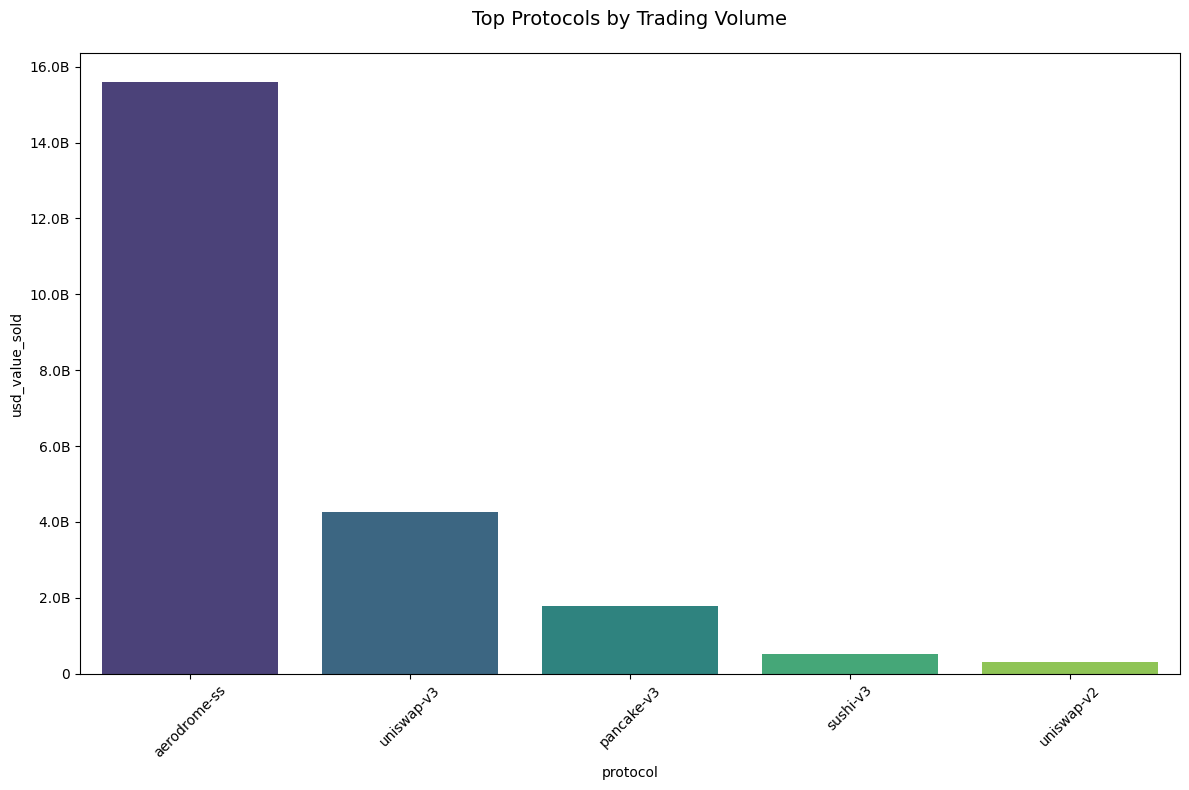

In [64]:

plot_styled_barchart(volume_df, 'protocol', 'usd_value_sold', 
                    'Top Protocols by Trading Volume')

/var/folders/d5/s2dpx1h57fx8pwt_52k13d7c0000gn/T/ipykernel_18543/373240557.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, palette='viridis')


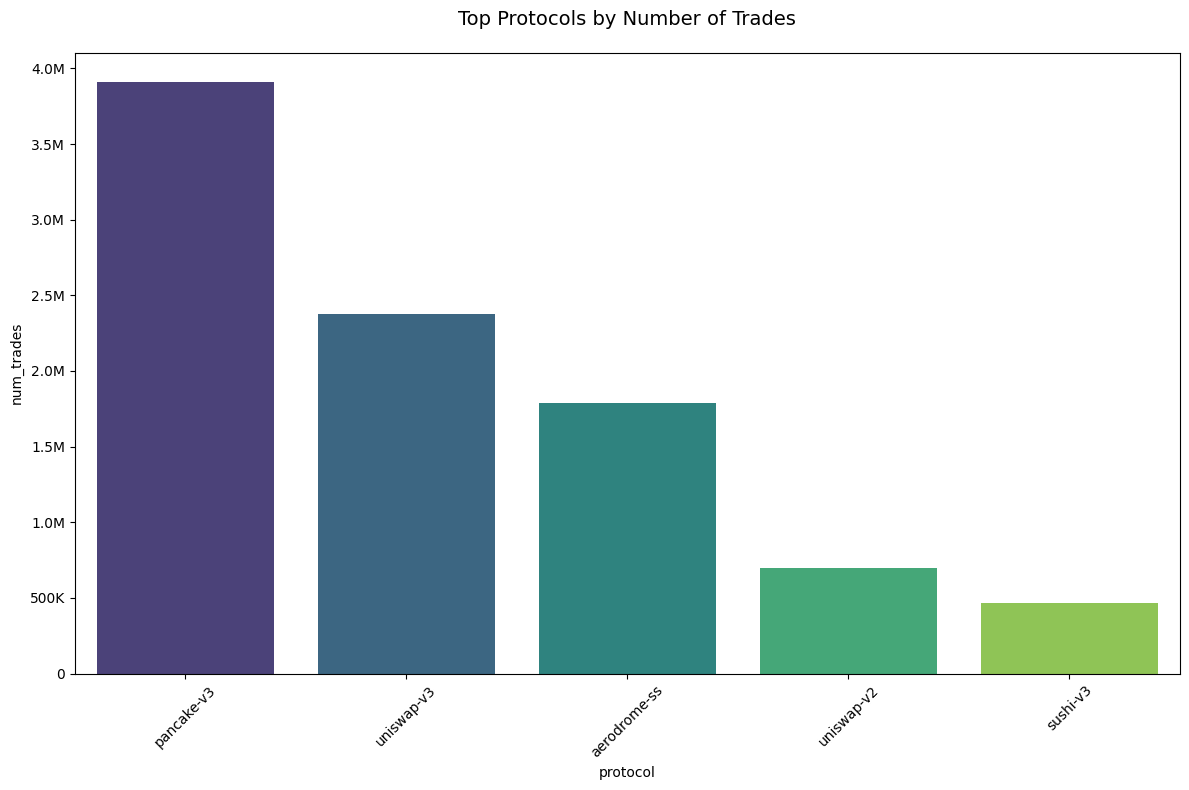

In [47]:
# Sort the dataframe by 'num_trades' in descending order
volume_df_sorted = volume_df.sort_values(by='num_trades', ascending=False)
#plot the values
plot_styled_barchart(volume_df_sorted, 'protocol', 'num_trades', 
                    'Top Protocols by Number of Trades')

In [48]:
#What is the typical size of a trade in USD value?
size_stats = con.execute("""
SELECT 
    approx_quantile(usd_value_sold, [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]) AS quantiles
FROM (
    SELECT 
        (s.amt_tokens_sold / POWER(10, t_sold.decimals)) * p_sold.rate_close AS usd_value_sold
    FROM reporting.swaps s
    JOIN reporting.tokens t_sold ON s.token_sold = t_sold.token
    JOIN reporting.prices p_sold 
        ON t_sold.id = p_sold.id 
        AND DATE_TRUNC('hour', s.block_timestamp) = p_sold.dollar_date_use
)
""").fetchone()[0]

print(f"""
Trade Size Percentiles (USD):
25th: ${size_stats[0]:,.2f}
50th (Median): ${size_stats[1]:,.2f}
75th: ${size_stats[2]:,.2f}
90th: ${size_stats[3]:,.2f}
95th: ${size_stats[4]:,.2f}
99th: ${size_stats[5]:,.2f}
""")


Trade Size Percentiles (USD):
25th: $68.02
50th (Median): $329.87
75th: $1,010.32
90th: $5,051.61
95th: $11,407.06
99th: $39,421.57



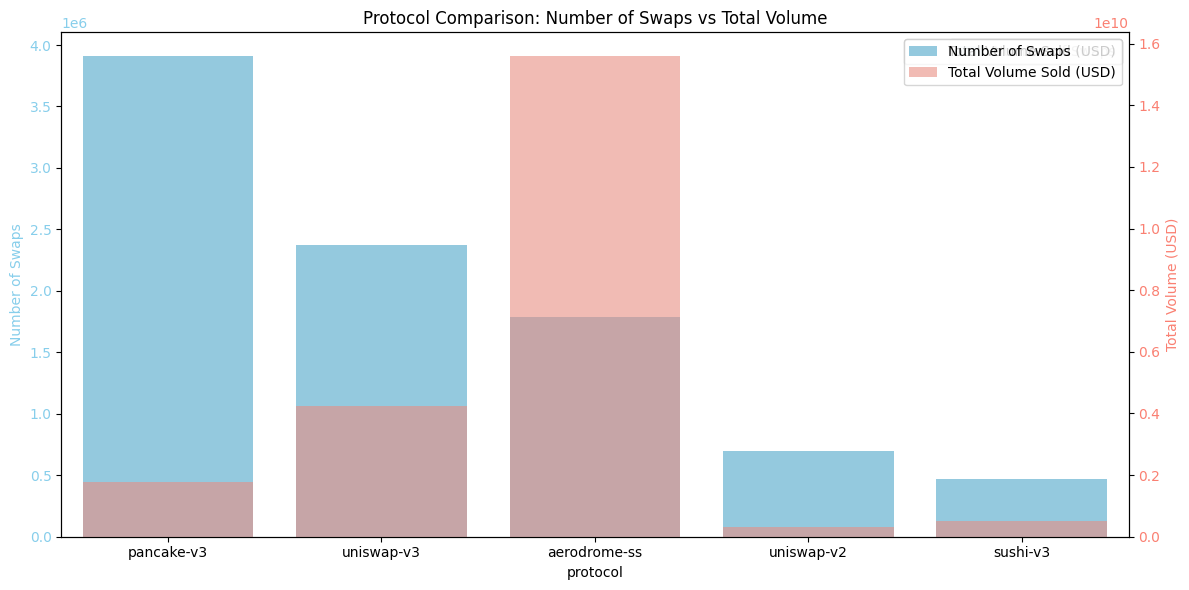

,protocol,num_trades,usd_value_sold,avg_trade_size_usd
0,aerodrome-ss,1789748,"15,589,276,664.46","8,710.32"
1,uniswap-v3,2373938,"4,250,597,523.05","1,790.53"
2,pancake-v3,3907730,"1,788,815,502.95",457.76
3,sushi-v3,468188,"505,738,987.36","1,080.20"
4,uniswap-v2,700537,"307,868,179.68",439.47


In [66]:
# Calculate average trade size per protocol and compare it to the volume
volume_df['avg_trade_size_usd'] = volume_df['usd_value_sold'] / volume_df['num_trades']

# Plot: Number of Trades vs Total Volume per Protocol
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for number of trades 
sns.barplot(
    data=volume_df.sort_values('num_trades', ascending=False),
    x='protocol', y='num_trades', color='skyblue', label='Number of Swaps', ax=ax1
)
ax1.set_ylabel('Number of Swaps', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Bar plot for total volume 
ax2 = ax1.twinx()
sns.barplot(
    data=volume_df.sort_values('num_trades', ascending=False),
    x='protocol', y='usd_value_sold', color='salmon', alpha=0.6, label='Total Volume Sold (USD)', ax=ax2
)
ax2.set_ylabel('Total Volume (USD)', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

plt.title('Protocol Comparison: Number of Swaps vs Total Volume')
plt.xlabel('Protocol')
plt.xticks(rotation=45)
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.tight_layout()
plt.show()

display(volume_df[['protocol', 'num_trades', 'usd_value_sold', 'avg_trade_size_usd']])

In [ ]:
#pancake has a large number of trades but pretty small volume compared to aerodrome-ss. 
#aerodrome has largest volume but not a lot of trades.
#seems aerodrome-ss would probably be attractive for seasoned 

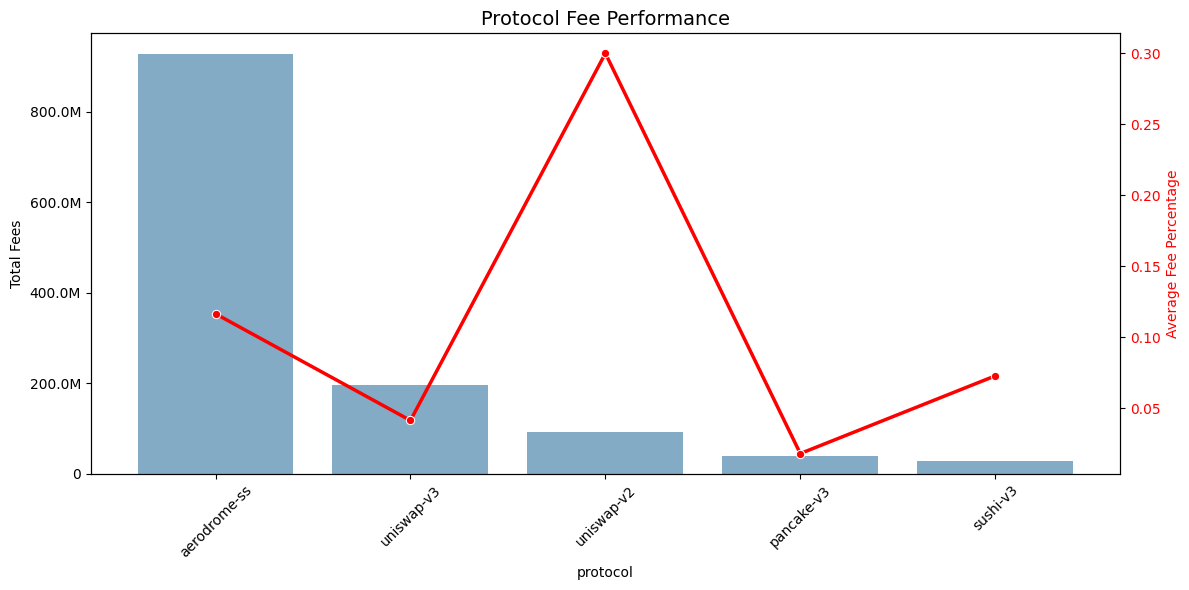

In [67]:
#Protocol fee analysis
fee_analysis = con.execute("""
SELECT
    protocol,
    AVG(fee_perc) AS avg_fee,
    SUM(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close * fee_perc) AS total_fees
FROM reporting.swaps s
JOIN reporting.tokens t ON s.token_sold = t.token
JOIN reporting.prices p ON t.id = p.id 
    AND DATE_TRUNC('hour', s.block_timestamp) = p.dollar_date_use
GROUP BY protocol
HAVING total_fees > 0
ORDER BY total_fees DESC;
""").fetchdf()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

sns.barplot(data=fee_analysis, x='protocol', y='total_fees', ax=ax1, alpha=0.6)
sns.lineplot(data=fee_analysis, x='protocol', y='avg_fee', ax=ax2, 
            color='red', marker='o', linewidth=2.5)

ax1.set_title('Protocol Fee Performance', fontsize=14)
ax1.set_ylabel('Total Fees')
ax2.set_ylabel('Average Fee Percentage', color='red')
ax1.yaxis.set_major_formatter(usd_formatter)
ax2.tick_params(axis='y', labelcolor='red')
ax1.xaxis.set_tick_params(rotation=45)
plt.tight_layout()
plt.show()

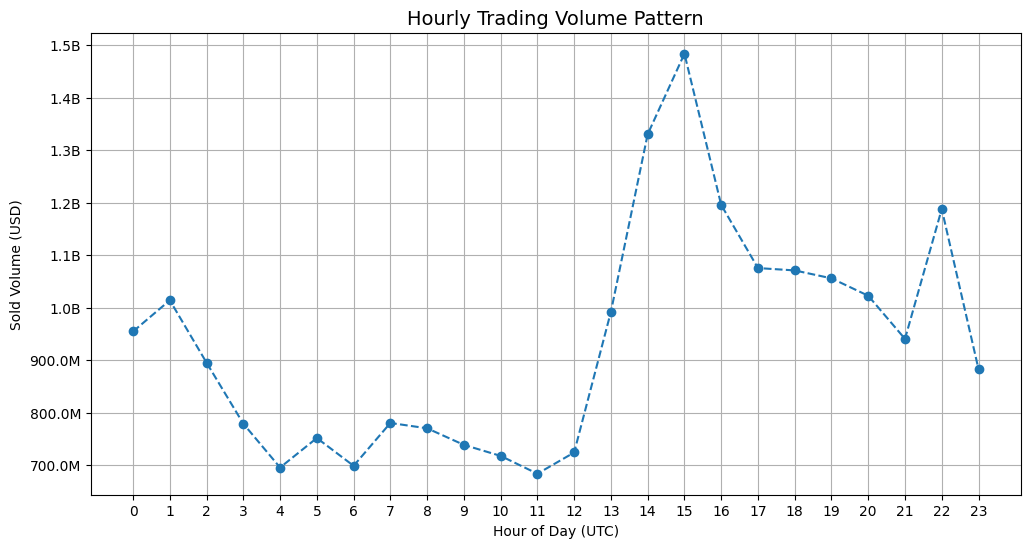

In [68]:
#When do the majority of the trades occur?
hourly_activity = con.execute("""
SELECT
    EXTRACT(HOUR FROM block_timestamp) AS hour,
    COUNT(*) AS trade_count,
    SUM(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close) AS usd_value_sold
FROM reporting.swaps s
JOIN reporting.tokens t ON s.token_sold = t.token
JOIN reporting.prices p ON t.id = p.id 
    AND DATE_TRUNC('hour', s.block_timestamp) = p.dollar_date_use
GROUP BY hour
ORDER BY hour;
""").fetchdf()

plt.figure(figsize=(12, 6))
plt.plot(hourly_activity['hour'], hourly_activity['usd_value_sold'], 
        marker='o', linestyle='--')
plt.title('Hourly Trading Volume Pattern', fontsize=14)
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Sold Volume (USD)')
plt.xticks(range(0, 24))
plt.gca().yaxis.set_major_formatter(usd_formatter)
plt.grid(True)
plt.show()

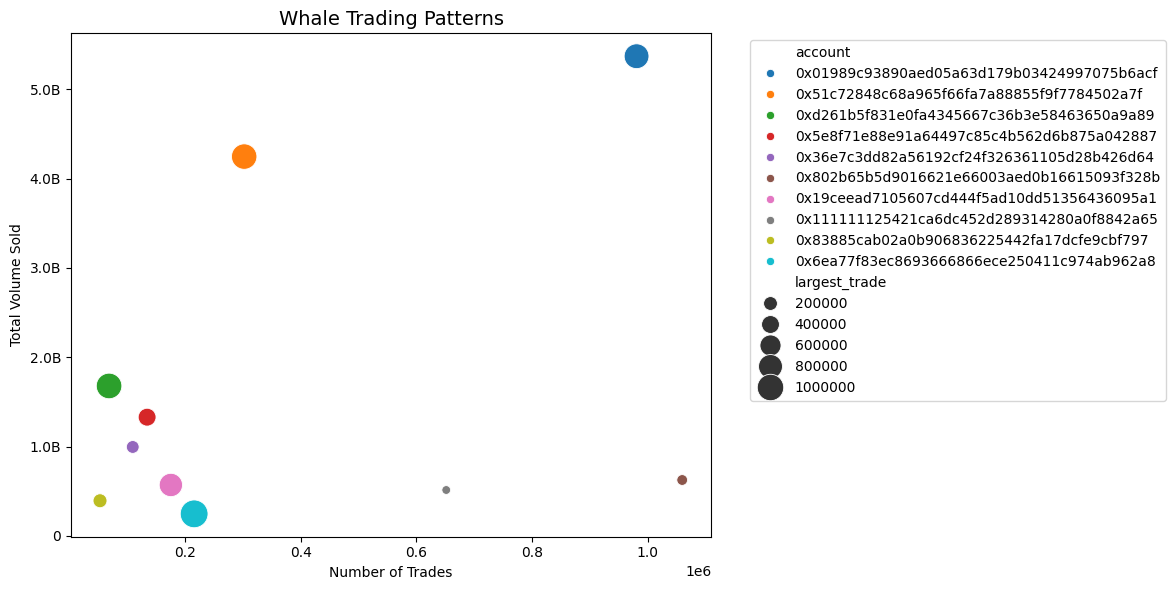

In [69]:
#check account activity
whale_activity = con.execute("""
WITH whale_stats AS (
    SELECT 
        account,
        COUNT(*) AS trade_count,
        SUM(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close) AS usd_value_sold,
        MAX(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close) AS largest_trade
    FROM reporting.swaps s
    JOIN reporting.tokens t ON s.token_sold = t.token
    JOIN reporting.prices p ON t.id = p.id 
        AND DATE_TRUNC('hour', s.block_timestamp) = p.dollar_date_use
    GROUP BY account
    HAVING usd_value_sold > 1000000  -- USD1M+ threshold
)
SELECT * FROM whale_stats
ORDER BY usd_value_sold DESC
LIMIT 10;
""").fetchdf()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=whale_activity, x='trade_count', y='usd_value_sold',
               size='largest_trade', hue='account', 
               sizes=(40, 400), palette='tab10')
plt.title('Whale Trading Patterns', fontsize=14)
plt.xlabel('Number of Trades')
plt.ylabel('Total Volume Sold')
plt.gca().yaxis.set_major_formatter(usd_formatter)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/d5/s2dpx1h57fx8pwt_52k13d7c0000gn/T/ipykernel_18543/373240557.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, palette='viridis')


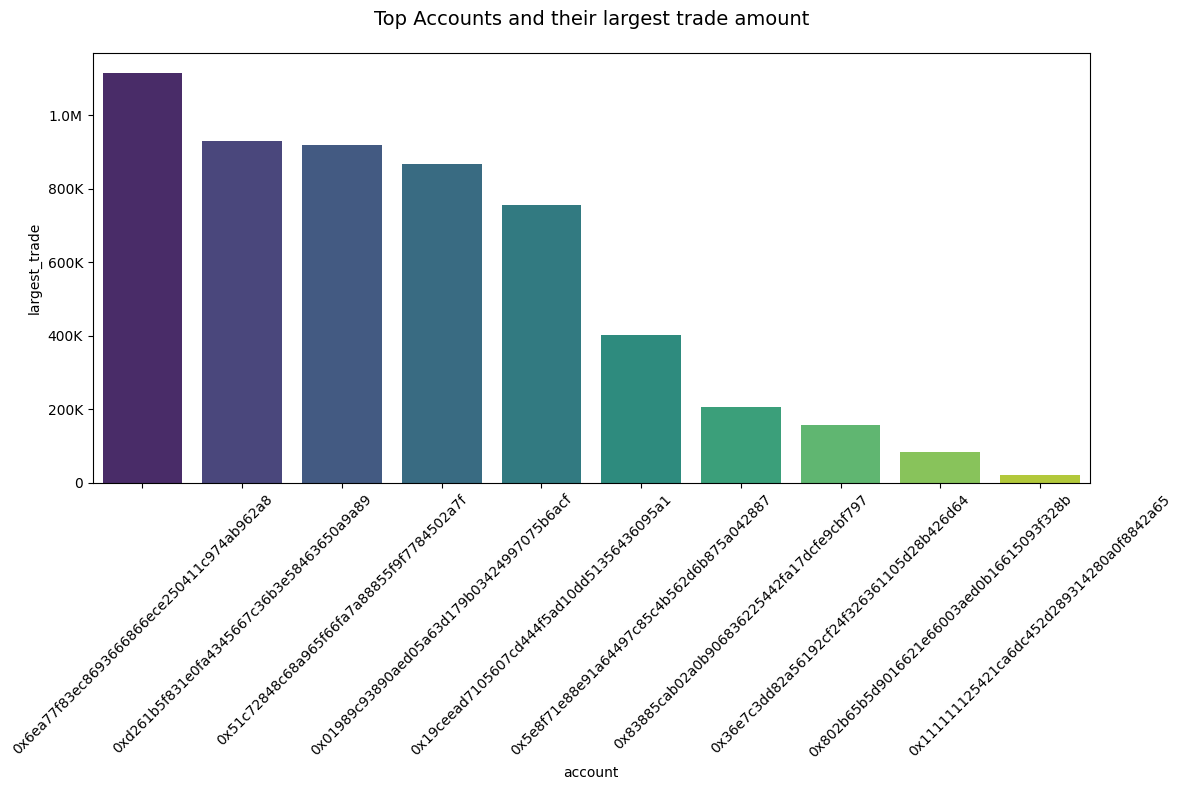

In [70]:
# Sort the dataframe by 'largest_trade' in descending order
whale_activity_sorted = whale_activity.sort_values(by='largest_trade', ascending=False)
#plot account with max trade
plot_styled_barchart(whale_activity_sorted, 'account', 'largest_trade', 
                    'Top Accounts and their largest trade amount')

/var/folders/d5/s2dpx1h57fx8pwt_52k13d7c0000gn/T/ipykernel_18543/373240557.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, palette='viridis')


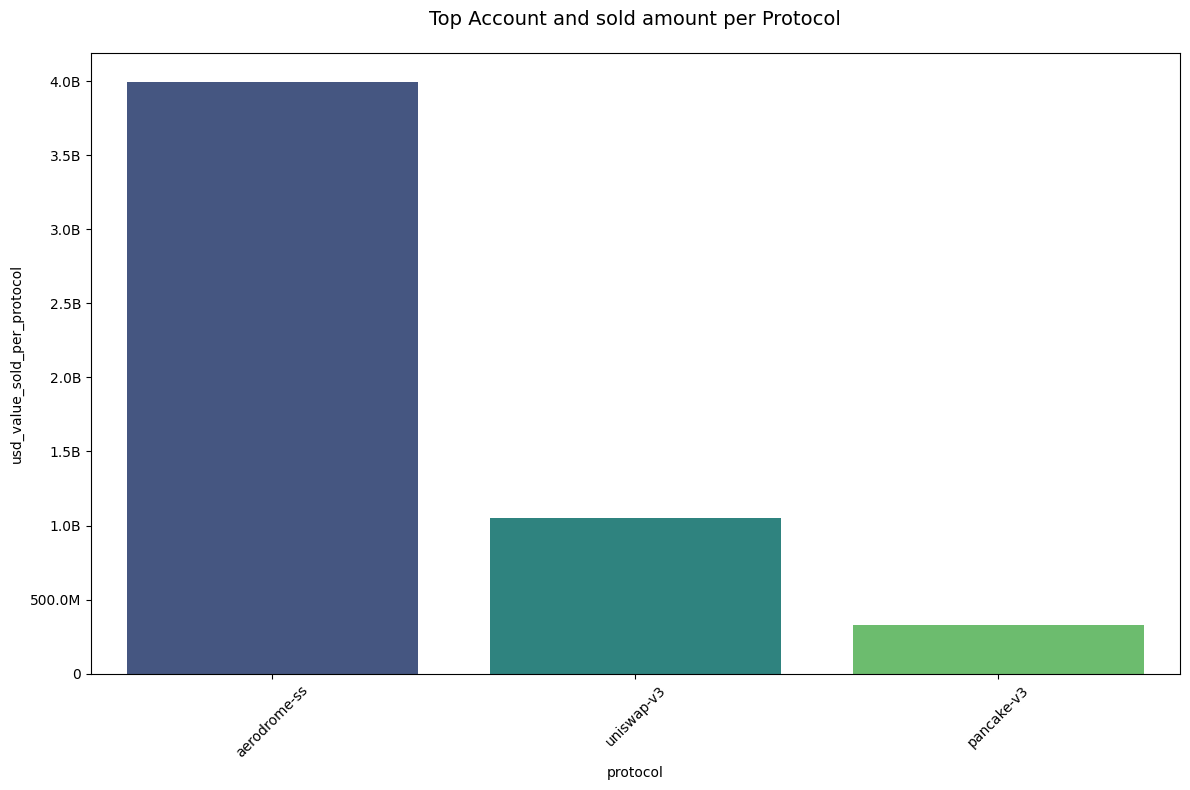

In [54]:
##curious to see that outlier account in terms of volume sold which protocol did it trade in > 3.0B in token value sold
top_whale_df = con.execute("""
WITH whale_stats AS (
    SELECT 
        account,
        COUNT(*) AS trade_count,
        SUM(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close) AS usd_value_sold,
        MAX(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close) AS largest_trade
    FROM reporting.swaps s
    JOIN reporting.tokens t ON s.token_sold = t.token
    JOIN reporting.prices p ON t.id = p.id 
        AND DATE_TRUNC('hour', s.block_timestamp) = p.dollar_date_use
    GROUP BY account
    HAVING usd_value_sold > 1000000  -- USD1M+ threshold
), top_whale as(
SELECT * FROM whale_stats
ORDER BY usd_value_sold DESC
LIMIT 1)
SELECT
s.account,
s.protocol,
SUM(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close) AS usd_value_sold_per_protocol,
MAX(amt_tokens_sold / POWER(10, t.decimals) * p.rate_close) AS largest_trade_per_protocol
FROM 
  reporting.swaps s
  JOIN top_whale tw on s.account = tw.account
  JOIN reporting.tokens t ON s.token_sold = t.token
  JOIN reporting.prices p ON t.id = p.id 
        AND DATE_TRUNC('hour', s.block_timestamp) = p.dollar_date_use
    GROUP BY s.account,s.protocol
ORDER BY usd_value_sold_per_protocol desc
;
""").fetchdf()

plot_styled_barchart(top_whale_df, 'protocol', 'usd_value_sold_per_protocol', 
                    'Top Account and sold amount per Protocol')


/var/folders/d5/s2dpx1h57fx8pwt_52k13d7c0000gn/T/ipykernel_18543/373240557.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, palette='viridis')


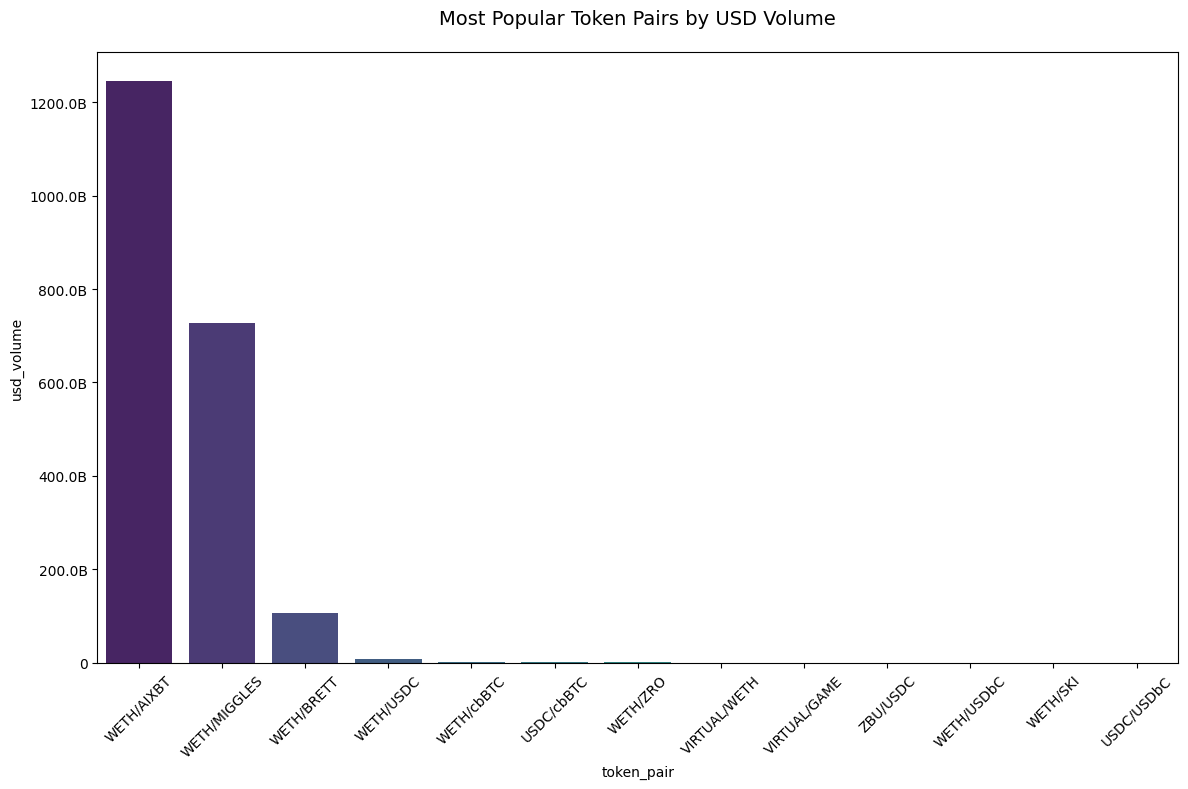

In [71]:
#popular token pairs
popular_pairs_df= con.execute( '''
SELECT
    t0.symbol || '/' || t1.symbol AS token_pair,
    COUNT(*) AS num_swaps,
    SUM(s.amt_tokens_sold / POWER(10, t0.decimals) * p.rate_close) AS usd_volume
FROM reporting.swaps s
JOIN reporting.tokens t0 ON s.token0 = t0.token
JOIN reporting.tokens t1 ON s.token1 = t1.token
JOIN reporting.prices p ON t0.id = p.id AND DATE_TRUNC('hour', s.block_timestamp) = p.dollar_date_use
GROUP BY  token_pair
ORDER BY  usd_volume DESC
LIMIT 100;
''').fetchdf()

plot_styled_barchart(popular_pairs_df, 'token_pair', 'usd_volume', 
                    'Most Popular Token Pairs by USD Volume')


In [ ]:
#Using token0 and token1 as this is crucial when analyzing token pairs data
#use token_bought and token_sold when checking outflows and inflows

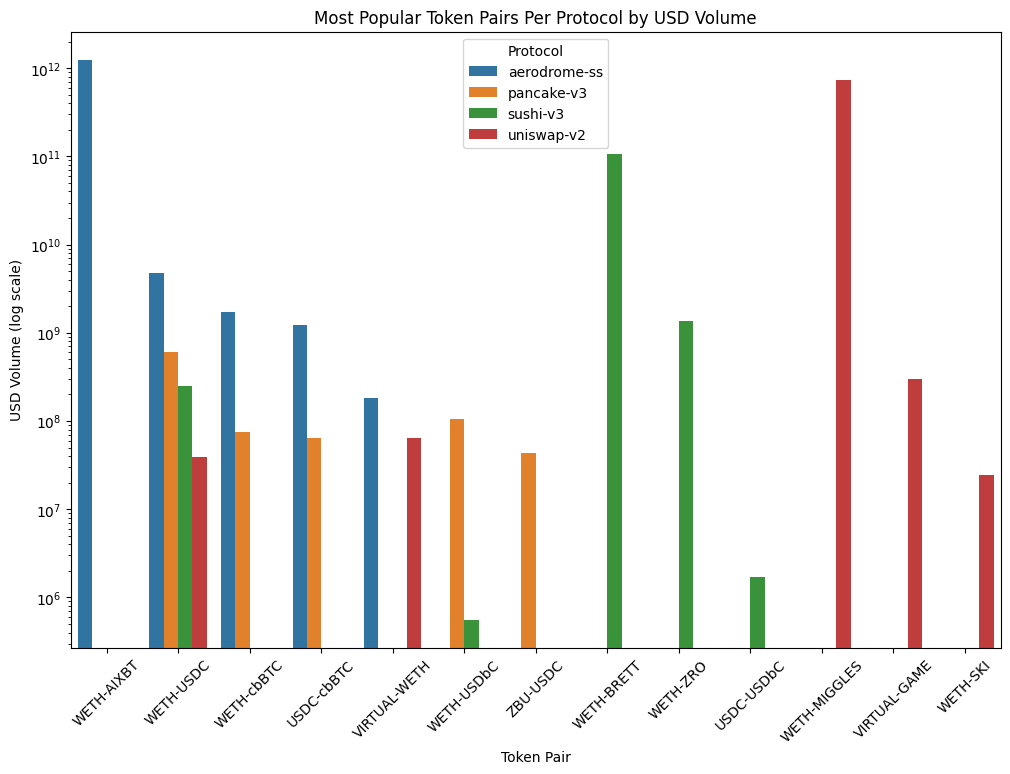

In [56]:
#popular token pairs by protocol
popular_pairs_df= con.execute( '''
SELECT
    s.protocol,
    t0.symbol || '-' || t1.symbol AS token_pair,
    COUNT(*) AS num_swaps,
    SUM(s.amt_tokens_sold / POWER(10, t0.decimals) * p.rate_close) AS usd_volume
FROM reporting.swaps s
JOIN reporting.tokens t0 ON s.token0 = t0.token
JOIN reporting.tokens t1 ON s.token1 = t1.token
JOIN reporting.prices p ON t0.id = p.id AND DATE_TRUNC('hour', s.block_timestamp) = p.dollar_date_use
GROUP BY s.protocol,  token_pair
ORDER BY s.protocol,  usd_volume DESC
LIMIT 20;
''').fetchdf()

# --- Visualization: Bar Plot ---
plt.figure(figsize=(12, 8))
sns.barplot(
    data=popular_pairs_df, 
    x='token_pair', 
    y='usd_volume',
    hue ='protocol'
)
plt.title('Most Popular Token Pairs Per Protocol by USD Volume')
plt.xlabel('Token Pair')
plt.ylabel('USD Volume (log scale)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(title='Protocol')
plt.show()

Top Tokens by Overall Activity:


,symbol,total_bought_usd,total_sold_usd
0,WETH,"9,298,042,604.85","9,670,065,727.57"
1,USDC,"8,784,560,231.60","8,548,182,697.23"
2,cbBTC,"3,342,919,604.49","3,215,702,656.60"
3,VIRTUAL,"482,256,024.31","482,020,510.21"
4,ZBU,"246,544,607.33","247,630,101.84"
5,AIXBT,"106,421,415.56","116,132,978.21"
6,USDbC,"107,108,763.79","106,871,280.24"
7,SKI,"24,175,810.03","24,936,009.36"
8,MIGGLES,"17,313,404.96","17,701,548.69"
9,GAME,"9,164,982.47","9,621,253.35"


<Figure size 1400x700 with 0 Axes>

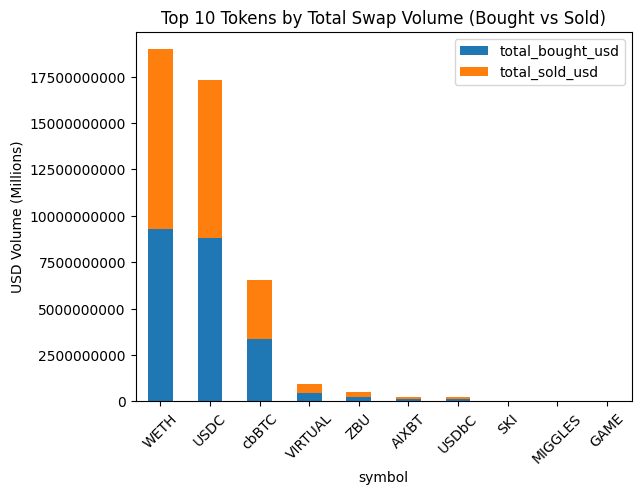

In [57]:
#most bought and sold token whole month
most_bought_sold_token_df =con.execute( """
WITH token_flows AS (
    SELECT 
        token_bought AS token, 
        amt_tokens_bought AS amount, 
        'bought' AS action,
        block_timestamp
    FROM reporting.swaps
    UNION ALL
    SELECT 
        token_sold AS token,
        amt_tokens_sold AS amount,
        'sold' AS action,
        block_timestamp
    FROM reporting.swaps
)
SELECT
    t.symbol,
    SUM(CASE WHEN tf.action = 'bought' 
        THEN (tf.amount / POWER(10, t.decimals)) * p.rate_close 
        ELSE 0 END) AS total_bought_usd,
    SUM(CASE WHEN tf.action = 'sold' 
        THEN (tf.amount / POWER(10, t.decimals)) * p.rate_close 
        ELSE 0 END) AS total_sold_usd
FROM token_flows tf
JOIN reporting.tokens t ON tf.token = t.token
JOIN reporting.prices p 
    ON t.id = p.id 
    AND DATE_TRUNC('hour', tf.block_timestamp) = p.dollar_date_use
GROUP BY t.symbol
ORDER BY total_bought_usd + total_sold_usd DESC
LIMIT 20;
""").fetchdf()


print("Top Tokens by Overall Activity:")
display(most_bought_sold_token_df.head(10))

# Visualization for whole month
plt.figure(figsize=(14, 7))
top_tokens = most_bought_sold_token_df.head(10).set_index('symbol')
top_tokens[['total_bought_usd', 'total_sold_usd']].plot(kind='bar', stacked=True)
plt.title('Top 10 Tokens by Total Swap Volume (Bought vs Sold)')
plt.ylabel('USD Volume (Millions)')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()


Top Tokens in aerodrome-ss:


,protocol,symbol,total_bought_usd,total_sold_usd
0,aerodrome-ss,WETH,"6,404,487,046.53","6,753,630,115.93"
1,aerodrome-ss,USDC,"5,950,510,159.96","5,737,125,741.29"
2,aerodrome-ss,cbBTC,"2,931,084,661.64","2,801,082,872.13"
3,aerodrome-ss,VIRTUAL,"182,953,861.91","181,304,956.91"
4,aerodrome-ss,AIXBT,"106,421,415.56","116,132,978.21"


<Figure size 1200x600 with 0 Axes>

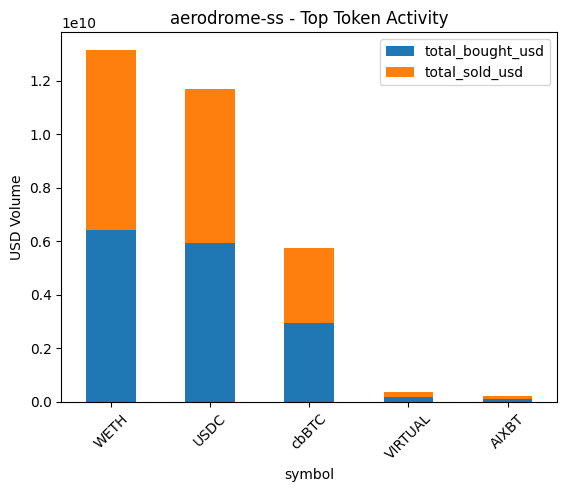


Top Tokens in pancake-v3:


,protocol,symbol,total_bought_usd,total_sold_usd
5,pancake-v3,WETH,"785,305,417.55","787,859,715.16"
6,pancake-v3,USDC,"713,595,405.54","710,844,247.35"
7,pancake-v3,cbBTC,"140,730,835.95","140,955,137.88"
8,pancake-v3,USDbC,"105,692,243.23","105,458,056.57"
9,pancake-v3,ZBU,"42,869,017.42","43,698,345.98"


<Figure size 1200x600 with 0 Axes>

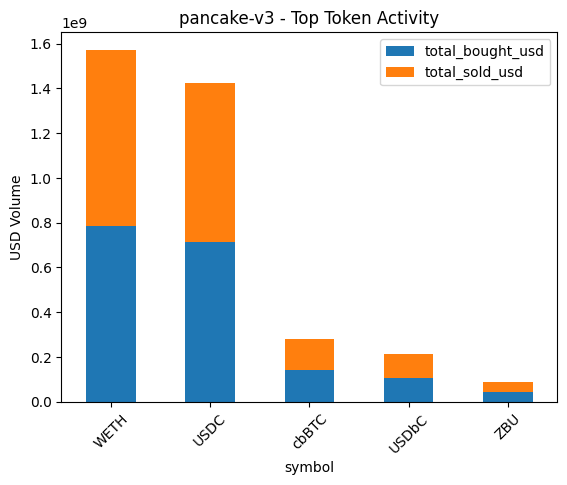


Top Tokens in sushi-v3:


,protocol,symbol,total_bought_usd,total_sold_usd
10,sushi-v3,WETH,"251,310,495.28","253,183,495.20"
11,sushi-v3,USDC,"249,215,371.00","247,710,174.28"
12,sushi-v3,BRETT,"1,711,745.67","1,978,834.52"
13,sushi-v3,ZRO,"1,451,983.68","1,453,259.69"
14,sushi-v3,USDbC,"1,416,520.56","1,413,223.67"


<Figure size 1200x600 with 0 Axes>

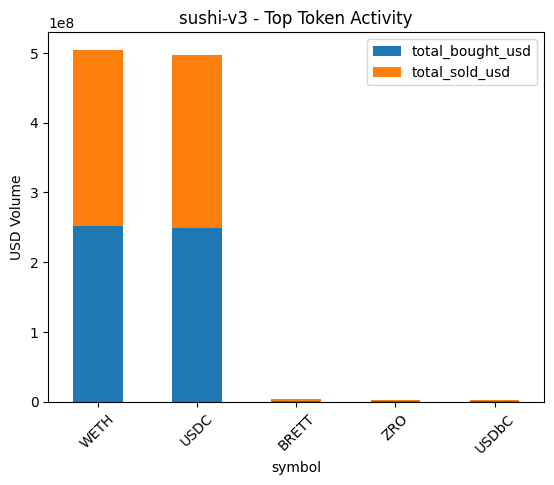

In [58]:
#most bought and sold token per protocol
# Per Protocol Analysis
most_bought_sold_token_protocol_df =con.execute( """
WITH token_flows AS (
    SELECT 
        protocol,
        token_bought AS token, 
        amt_tokens_bought AS amount, 
        'bought' AS action,
        block_timestamp
    FROM reporting.swaps
    UNION ALL
    SELECT 
        protocol,
        token_sold AS token,
        amt_tokens_sold AS amount,
        'sold' AS action,
        block_timestamp
    FROM reporting.swaps
)
SELECT
    tf.protocol,
    t.symbol,
    SUM(CASE WHEN tf.action = 'bought' 
        THEN (tf.amount / POWER(10, t.decimals)) * p.rate_close 
        ELSE 0 END) AS total_bought_usd,
    SUM(CASE WHEN tf.action = 'sold' 
        THEN (tf.amount / POWER(10, t.decimals)) * p.rate_close 
        ELSE 0 END) AS total_sold_usd
FROM token_flows tf
JOIN reporting.tokens t ON tf.token = t.token
JOIN reporting.prices p 
    ON t.id = p.id 
    AND DATE_TRUNC('hour', tf.block_timestamp) = p.dollar_date_use
GROUP BY tf.protocol, t.symbol
ORDER BY tf.protocol, total_bought_usd + total_sold_usd DESC;
""").fetchdf()


# Analyze top 3 protocols
protocols = most_bought_sold_token_protocol_df['protocol'].unique()[:3]  

for protocol in protocols:
    proto_df = most_bought_sold_token_protocol_df[most_bought_sold_token_protocol_df['protocol'] == protocol].head(10)
    
    print(f"\nTop Tokens in {protocol}:")
    display(proto_df)
    
    plt.figure(figsize=(12, 6))
    proto_df.set_index('symbol')[['total_bought_usd', 'total_sold_usd']].plot(kind='bar', stacked=True)
    plt.title(f'{protocol} - Top Token Activity')
    plt.ylabel('USD Volume')
    plt.xticks(rotation=45)
    plt.show()